## Get the outputs

Lab41 trained a DenseCap model using Visual Genome's (hereafter VG) object tags. Here we run the model to produce tags for all images to get evaluatation metrics.

Note: Out of the box, `run_model.lua` will output a copy of the image(s) and a result.json file. We've modified the file to only write the json output for a 2x speed improvement -- form 1 sec/image to 0.5 sec/image.

```bash
cd densecap/
th run_model.lua \
-checkpoint densecap/models/single-object/checkpoint.t7 \
-input_batch_dir visual-genome/batches/ \
-output_vis_dir densecap/predictions/single-object```

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import sys
sys.path.append("attalos/")
from attalos.evaluation.evaluation import Evaluation
from oct2py import octave
octave.addpath('attalos/attalos/evaluation/')
import os
import json
import h5py
import numpy as np
from PIL import Image
from scripts import loaders
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
from IPython.core.display import display
from IPython.core.pylabtools import figsize
from scripts import load_combine_json_dir, print_list_to_columns

%matplotlib inline
plt.style.use('ggplot')

Keep all the file paths here so we don't need to hunt for them later

In [2]:
# directory with result_%i.json files form DenseCap inference
json_dir = "densecap/predictions/single-object"

# The training data
object_hd5 = 'VG-object-regions.h5'
object_dict = 'VG-object-regions-dicts.json'

# base image directory
imgdir = "visual-genome/images/"

In [3]:
print("Loading predictions (This will take some time)...")
results = load_combine_json_dir(json_dir, loaders.load_output_json)
print("Done!")

Loading predictions (This will take some time)...
Loaded 22 files
Done!


## Training data is separated into two files

`VG-object-regions.h5` contains all images, labels, bounding boxes and other important information for training.
`VG-object-regions-dicts.json` holds all the index mappings for images and word tokens. 

In [4]:
# simple JSON data. Holds index mappings for images and word tokens
gt_map = loaders.json_load(object_dict)

# This HDF5 file is large (127 GB). We only want labels. We'll use the 
# json data to complete the map
with h5py.File(object_hd5, 'r') as hf:    
    # labels array 
    labels = np.array(hf.get('labels'))
    
    # We will use these indices to take slices of labels. 
    # The mapping is filename_to_idx -- img_to_first_box, img_to_last_box -- labels
    img_to_first_box = np.array(hf.get('img_to_first_box'))
    img_to_last_box = np.array(hf.get('img_to_last_box'))    
    

### Label-Image mapping
The labels and images are separated into several datasets across hdf5 and json files. The funciton below consumes part of the HDF5 file that we've loaded above, namely `labels`, `img_to_first_box`, and `img_to_last_box`. Now we can do things like pass a filename to get the corresponding ground truth labels.

**Important**: Lua is 1 indexed and Python is 0 indexed. Because of this, the word and image index mappings start at 1 so we need to subtract 1 from each to work in Python. 

In [5]:
def get_corresponding_labels(filename, reference_dict, labels_arr, first_box, last_box):
    """This function will do the mapping from filename to label
    
    Parameters
    ----------
    filename : str
        name of an image file. Just the os.path.basename of the file. e.g. '55.jpg'
    reference_dict : dict
        object regions dict used for model training
    labels_arr : numpy.array
        training lables array
    first_box : numpy.array
        img_to_first_box array from training data
    last_box : numpy.array
        img_to_last_box array from training data
    
    Returns
    -------
    numpy.array with label IDs
    """
    
    idx = reference_dict['filename_to_idx'][filename] - 1
    slice_start = first_box[idx]
    slice_end = last_box[idx]
    return labels[slice_start:slice_end]

In [6]:
n_gt_images = len(gt_map['idx_to_filename'].items())
n_tokens = len(gt_map['token_to_idx'].items())
n_imgs = len(results.keys())

# model predicts 1000 boxes per image
n_pred_boxes = n_imgs * 1000
print("Tokens: {0:,}\nPrediction Images: {1:,}\nPredicted Boxes: {3:,}\
\n\nGround Truth Images: {2:,}".format(n_tokens, n_imgs, n_gt_images, n_pred_boxes))

Tokens: 4,688
Prediction Images: 108,073
Predicted Boxes: 108,073,000

Ground Truth Images: 87,396


## Visual Inspection

We need to make sure these predictions and ground truth values make sense. Below we display an image along with it's ground truth and predicted detections. 

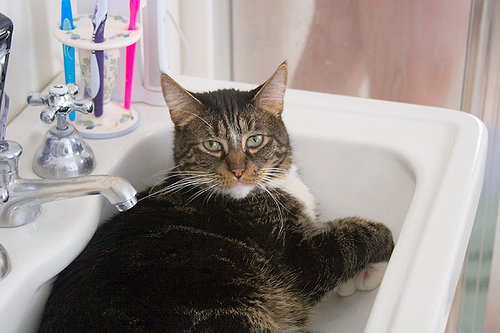

**************************************************
Ground Truth labels:

shower        faucet        eye           cat           
toothbrush    person        sink          handle        ear           
holder        toothbrushes  ground        
**************************************************
Predicted labels:

straw           floor           brush           mirror          
candle          chair           cat             ground          lid             
eye             tire            cup             wall            window          
hill            curtain         white           door            toilet paper    
whiskers        toothbrush      spoon           sink            shadow          
ear             table           collar          water           faucet          
fur             light           paw             face            shower          
edge            nose            bottle          bathtub         shower curtain  
ears            


In [7]:
fname = np.random.choice(gt_map['filename_to_idx'].keys())
label_codes = get_corresponding_labels(fname, gt_map, labels, img_to_first_box, img_to_last_box)

img = Image.open(os.path.join(imgdir, fname))
display(img)

terms = []
rows, cols = label_codes.shape
for row in xrange(rows):
    obj = ''
    words = []
    for col in xrange(cols):
        val_num = label_codes[row, col]
        val = str(val_num)
        
        if (val_num > 0) and gt_map['idx_to_token'].has_key(val):
            words.append(gt_map['idx_to_token'][val])
        terms.append(" ".join(words))
        
print("*" * 50 + "\nGround Truth labels:\n")
print_list_to_columns(list(set(terms)))
pred_labels = list(set(map(lambda x : " ".join(x['names']), results[fname])))
print("*" * 50 + "\nPredicted labels:\n")
print_list_to_columns(pred_labels)

## Creating the Predictions Array
Now we'll load up the prediction array with the corresponding score. The output array will be $I \times T$ where $I$ is the number of images and $T$ is the number of tokens.

In [8]:
def get_tokens_and_score(bbox_predictions, token_to_idx):
    """This function will gather the unique tokens and 
    the best score assigned to each
    
    Parameters
    ----------
    bbox_predictions : dict
        dictionary with predictions from DenseCap. Each 
        item should have a 'score' and 'names'
    token_to_idx : dict
        mapping of words to an index/unique number
        
    Returns
    --------
    Dictionary with {term: score} mappings, dictionary 
    with missed words and counts {word, count}
    """
    out = {}
    missed = Counter()
    for item in bbox_predictions:
        name = item['names']
        
        # each name should be a list with 1 item 
        err = "Too maney tokens! Should have 1 but this one has {0}".format(len(name))
        assert len(name) == 1, err
        
        name = name[0]
        
        # attempt to squish the token into existing vocab
        name_stripped = name.replace(' ', '')
        
        if token_to_idx.has_key(name):
            # 1-indexing to 0-indexing densecap/preprocessing.py 44
            name_idx = token_to_idx[name] - 1
    
        elif token_to_idx.has_key(name_stripped):
            # 1-indexing to 0-indexing densecap/preprocessing.py 44
            name_idx = token_to_idx[name_stripped] - 1 
            
        else:
            # This keeps track of the terms out of 
            # training vocabulary. 
            missed[name] += 1
            continue 
        
        score = item['score']
        if out.has_key(name_idx):
            cur_score = out[name_idx]
            if score > cur_score:
                out[name_idx] = score
        else:
            out[name_idx] = score
    return out, missed
    

In [9]:
# array needs to be Images X Tokens
prediction_arr = np.zeros(shape=(n_gt_images, n_tokens), dtype=np.float32)

prediction_set = {}

# Sometimes the model predicts compound phrases like 
# "red hair" and the training data may only have red OR hair
# but not combined. We believe it may be a remnent of using
# a LSTM instead of a true single class predictor
oov = Counter()

# get the best score for each unique token
for fname, preds in results.iteritems():
    if gt_map['filename_to_idx'].has_key(fname):
        
        # 1-indexing to 0-indexing densecap/preprocessing.py 44
        idx = gt_map['filename_to_idx'][fname] - 1 
        
        scores, missed = get_tokens_and_score(preds, gt_map['token_to_idx'])
        oov.update(missed)
        
        # collect unique tokens for manual precision recall
        tokens = set()
        
        for word_idx, score in scores.iteritems():
            prediction_arr[idx, word_idx] =  score
            tokens.add(word_idx)
        
        prediction_set[fname] = tokens

There is a discrepancy between the training labes and the ground truth set. Here we plot tokens from the prediction set that were not in the ground truth. 

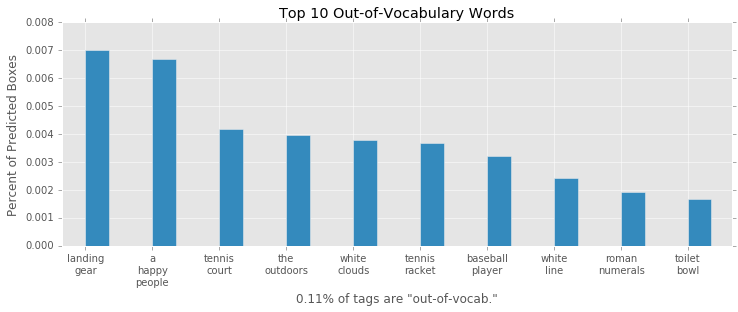

In [10]:
figsize(12, 4)
top = 10
width = 0.35
ind = np.arange(top)
values = map(lambda x: x[1], oov.most_common(top))
percent = map(lambda x : x / n_pred_boxes * 100, values)
lables = map(lambda x: "\n".join(x[0].split(' ')), oov.most_common(top))
fig, ax = plt.subplots()
ax.bar(ind + width, percent, width=width)
ax.set_ylabel("Percent of Predicted Boxes")
ax.set_title("Top 10 Out-of-Vocabulary Words")
ax.set_xticks(ind + width)
ax.set_xticklabels(lables)
ax.set_xlabel("{0:0.2%} of tags are \"out-of-vocab.\"".format(sum(oov.values()) / n_pred_boxes))
plt.show()

## Creating Test Evalutation Array

Here we're loading the ground truth data into an array the same shape as the prediction array.

In [11]:
gt_array = np.zeros_like(prediction_arr)

gt_set = {}

# Loop over the ground truth map to fill in the 
# ground truth array 
for fname, idx in gt_map['filename_to_idx'].iteritems():
    gt_label_arr = get_corresponding_labels(fname, gt_map, \
                                            labels, img_to_first_box, \
                                            img_to_last_box)
    # need to go through each box and find non-zero tokens
    rows, cols = gt_label_arr.shape
    
    # 1-indexing to 0-indexing densecap/preprocessing.py 44
    idx -= 1
    
    tokens = set()
    for row in xrange(rows):
        for col in xrange(cols):
            val = gt_label_arr[row, col]
            if val > 0:
                # 1-indexing to 0-indexing densecap/preprocessing.py 44
                val -= 1
                tokens.add(val)
                # To one-hot
                gt_array[idx, val] = 1
    gt_set[fname] = tokens

## Running the evaluation code

In [12]:
[precision,recall,f1] = octave.evaluate(gt_array.T, np.abs(prediction_arr).T, 5)
print("Precision: {0:0.3f}".format(precision))
print("Recall: {0:0.3f}".format(recall))
print("F-1: {0:0.3f}".format(f1))

Precision: 0.101
Recall: 0.018
F-1: 0.031


These performance metrics reults are not very good and are not representative of the model's performance judging from visual inspection of a small sample. To overcome this, we'll look at a simplified version of the metrics. For precision, we'll divid the size of the intersection over the size of the union. 

$$\text{precision} = \frac{|\{\text{test}\} \cap \{\text{predicted}\}|}{|\{\text{test}\} \cup \{\text{predicted}\}|}$$

Recall evaluates the correctly predicted labels over the set of all correct labels. Since a false negative here is the absence of a predicted label and a false positive is the addition of a label we'll look at the size of the intersection of the actual and predicted over the size of the actual labels for each.

$$\text{recall} = \frac{|\{\text{test}\} \cap \{\text{predicted}\}|}{|\{\text{test}\}|}$$

And finally the F-1 score

$$\text{f1} = 2 \cdot \frac{(\text{precision} \cdot\text{recall})}{(\text{precision} + \text{recall})}$$

In [13]:
intersection = 0
union = 0
recall_denom = 0

for fname in gt_set.iterkeys():
    a = gt_set[fname]
    b = prediction_set[fname]
    intersection += len(a.intersection(b))
    union += len(a.union(b))
    recall_denom += len(a)

precision = intersection / union
recall = intersection / recall_denom
f1 = 2 * (precision * recall) / (precision + recall)
print("Precision: {0:0.3f}".format(precision))
print("Recall: {0:0.3f}".format(recall))
print("F-1: {0:0.3f}".format(f1))

Precision: 0.208
Recall: 0.449
F-1: 0.284
